## **Preparation for the project**


*Shevchenko Viktoriia*

Intel Image Classification - [Data](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data)

**0. Importing and Installation**





In [68]:
pip install kagglehub


In [69]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import kagglehub
from torchvision import transforms

**1. Load data feom Kaggle**

In [70]:

path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


List all directories in the specified path

In [71]:
directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

for directory in directories:
    print(directory)

seg_pred
seg_test
seg_train


Paths for the each directory

In [72]:
x  = '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2'
path = Path(x)
path.ls()

(#3) [Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_pred'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train')]

**2. Work with the Training dataset**

Розглянемо, які в нас шляхи до кожно класу (subdirectory).

In [73]:
x  = '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train'
path = Path(x)
path.ls()

(#6) [Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/street'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/glacier'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/sea'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/mountain'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/buildings'),Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/forest')]

Кількість класів

In [74]:
# List all class directories
class_dirs = path.ls()

# Count the number of classes (directories)
num_classes = len(class_dirs)
print(f"Number of classes: {num_classes}")


Number of classes: 6


In [75]:

class_dirs = [d for d in path.iterdir() if d.is_dir()]

for class_dir in class_dirs:
    image_files = list(class_dir.glob('*.*'))
    print(f"Class '{class_dir.name}' contains {len(image_files)} images.")


Class 'street' contains 1524 images.
Class 'glacier' contains 1538 images.
Class 'sea' contains 1455 images.
Class 'mountain' contains 1607 images.
Class 'buildings' contains 1401 images.
Class 'forest' contains 1452 images.


*коментар:*

- можемо побачити, що датасет складається з 6 класів: street, glacier, sea, mountain, buildings, forest.
- також, на перший погляд, можна сказати, що немає дизбалансу серед класів і всі містять приблизно однакову кількість зображень. В діапазоні від 2200-2400.


**
під час виведення гісторгами, ми зможемо краще переконатись в цій гіпотезі*

**Quick glance on the test dataset**

In [76]:

x_test = '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test'
path_test = Path(x_test)

class_dirs_test = [d for d in path_test.iterdir() if d.is_dir()]

for class_dir in class_dirs_test:
    image_files = list(class_dir.glob('*.*'))
    print(f"Class '{class_dir.name}' contains {len(image_files)} images.")


Class 'street' contains 501 images.
Class 'glacier' contains 553 images.
Class 'sea' contains 510 images.
Class 'mountain' contains 525 images.
Class 'buildings' contains 437 images.
Class 'forest' contains 474 images.


*коментар:*
- тестова множина теж немає дизбалансу класів, та кожен з яких містить близько 500 елементів.


**3. Create validation dataset**

In [77]:
from sklearn.model_selection import train_test_split
import shutil




In [78]:

train_dir = Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train')
val_dir = Path('/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_val')  # Це буде ваш новий валідаційний набір

val_dir.mkdir(parents=True, exist_ok=True)

class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]

for class_dir in class_dirs:
    files = list(class_dir.glob('*.*'))
    train_files, val_files = train_test_split(files, test_size=0.2)  # 20%

    val_class_dir = val_dir / class_dir.name
    val_class_dir.mkdir(parents=True, exist_ok=True)

    for file in val_files:
        shutil.move(str(file), str(val_class_dir / file.name))

print("Валідаційна множина успішно створена.")


Валідаційна множина успішно створена.


для подальшої зручності в роботі  з шляхами, збережемо їх в змінні

In [79]:
train_path =  '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train'  # Тренувальний датасет
val_path =  '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_val'  # Валідаційний датасет (створений з тренувального)
test_path = '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test'  # Тестовий датасет
pred_path =  '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_pred/seg_pred'  # Датасет для прогнозування (pred)

Перевірка кількості зображень в тренувальній та валідаційній множині.

In [80]:

print("\nКількість зображень в тренувальній множині:")
for class_dir in class_dirs:
    num_train_images = len(list(class_dir.glob('*.*')))
    print(f"Class '{class_dir.name}': {num_train_images} images")

print("\nКількість зображень в валідаційній множині:")
for class_dir in class_dirs:
    val_class_dir = val_dir / class_dir.name
    num_val_images = len(list(val_class_dir.glob('*.*')))
    print(f"Class '{class_dir.name}': {num_val_images} images")


Кількість зображень в тренувальній множині:
Class 'street': 1219 images
Class 'glacier': 1230 images
Class 'sea': 1164 images
Class 'mountain': 1285 images
Class 'buildings': 1120 images
Class 'forest': 1161 images

Кількість зображень в валідаційній множині:
Class 'street': 1163 images
Class 'glacier': 1174 images
Class 'sea': 1110 images
Class 'mountain': 1227 images
Class 'buildings': 1071 images
Class 'forest': 1110 images


**4. Перетворення в тензори**

In [81]:
from torchvision import datasets  # Import datasets from torchvision
from torch.utils.data import DataLoader

In [82]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Змінюємо розмір зображень до 224x224
    transforms.ToTensor(),  # Перетворюємо зображення у тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормалізація
])


In [83]:
train_data = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [84]:
val_data = datasets.ImageFolder(root=val_path, transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [85]:
test_data = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


**Перевірка пошкоджених зображень у тренувальній множині**

In [86]:
from PIL import Image

def check_for_corrupted_images(directory_path):
    corrupted_images = []
    for class_dir in os.listdir(directory_path):
        class_path = os.path.join(directory_path, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print(f"Пошкоджене зображення: {file_path}")
                    corrupted_images.append(file_path)
    return corrupted_images

corrupted_images = check_for_corrupted_images(train_path)
print(f"Знайдено пошкоджених зображень: {len(corrupted_images)}")


Знайдено пошкоджених зображень: 0


**5. Data Augmentation**

In [87]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [88]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [89]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=train_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_path, transform=test_transforms)

Створемо гістограму для того щоб подивитись кількість зображень в кожному класі (train dataset)

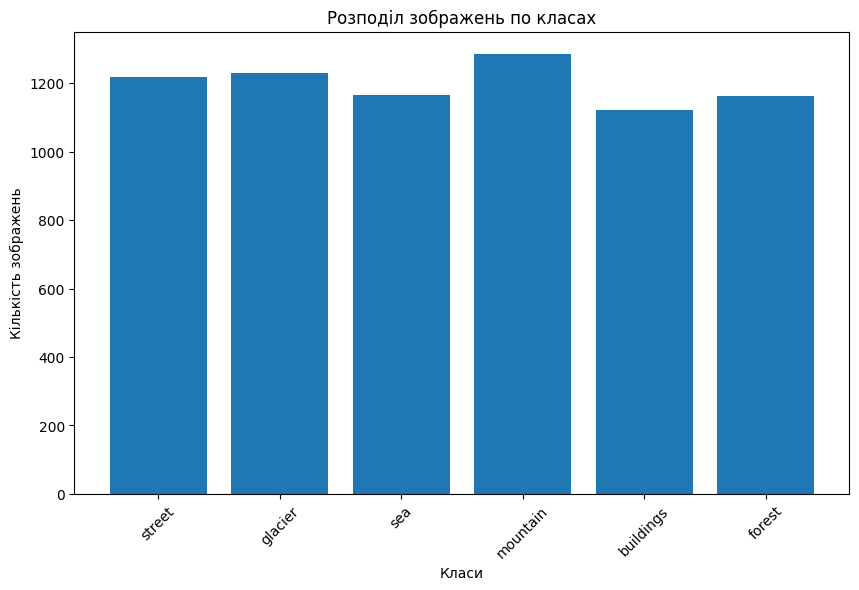

In [90]:


def count_images_per_class(directory_path):
    class_counts = {}
    for class_dir in Path(directory_path).iterdir():
        if class_dir.is_dir():
            class_counts[class_dir.name] = len(list(class_dir.glob('*.*')))  # Підраховуємо всі файли
    return class_counts

class_counts = count_images_per_class(train_path)

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Класи')
plt.ylabel('Кількість зображень')
plt.title('Розподіл зображень по класах')
plt.xticks(rotation=45)
plt.show()




**Візуалізація 3 випадкових зображень для кожного класу**

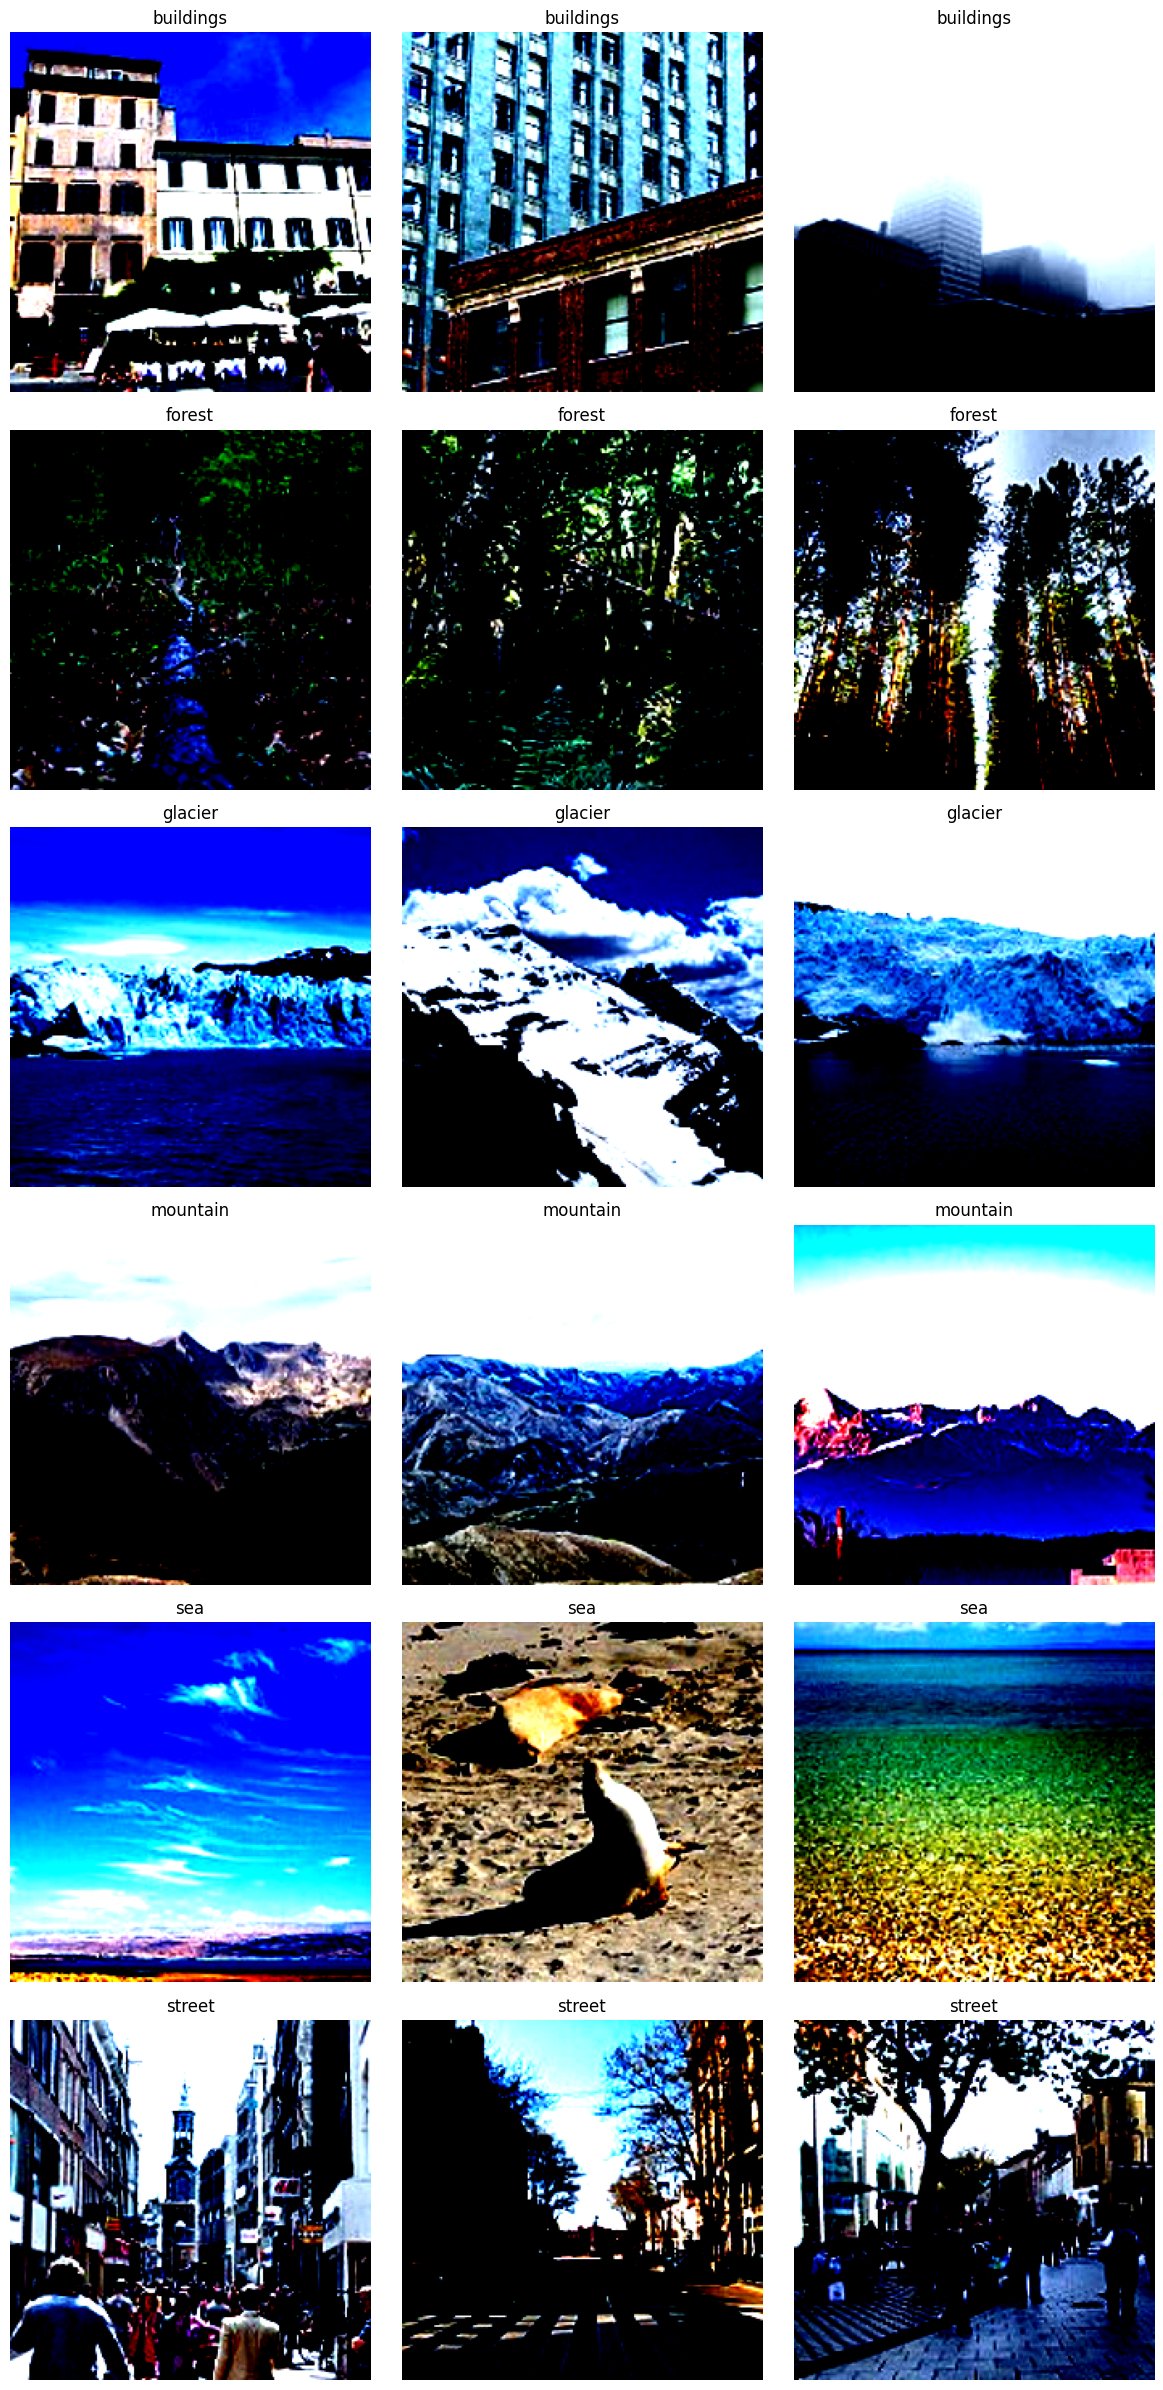

In [91]:
import random


def visualize_samples(train_data, num_samples=3):
    class_names = train_data.classes
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(12, 4 * len(class_names)))

    for i, class_name in enumerate(class_names):
        class_idx = train_data.class_to_idx[class_name]
        indices = [idx for idx, label in enumerate(train_data.targets) if label == class_idx]
        random_indices = random.sample(indices, num_samples)

        for j, idx in enumerate(random_indices):
            img, label = train_data[idx]
            axes[i, j].imshow(img.permute(1, 2, 0))
            axes[i, j].set_title(f"{class_name}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


visualize_samples(train_data, num_samples=3)


**Аналіз датасету**

-  Датасет містить 6 класів: street, glacier, sea, mountain, buildings, forest.
- Дизбалансу серед класів немає, що спростить нам тренування моделі та має позитивно вплинути на результат.
- Гістограма показує, що найбільше зображень у класаі 'mountain', хоча кількість не сильно відрізняється від інших класів.
- загалом датасет якісний, що полегшить подальшу роботу з даними.

